In [1]:
#salt2_fit_TEST_sample_log10x0_mb_cov


In [2]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from astropy.cosmology import Planck15 as cosmo 
from astropy.io import fits
%matplotlib inline

In [3]:
sn_machine='/Users/mariavincenzi/PhD/SNChallenge/supernova-machine/'

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import time

import sys
import os
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
max_ml_algorithms_file=sn_machine+'max_ml_algorithms.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_ml_algorithms_file)))
import max_ml_algorithms as ml_algorithms#, max_tools as tools
max_tools_file=sn_machine+'max_tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_tools_file)))
import max_tools as tools

max_grid_search_file=sn_machine+'max_grid_search.py'
sys.path.append(os.path.dirname(os.path.expanduser(max_grid_search_file)))
import max_grid_search as grid_search



/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This 

In [4]:
def prepare_data4ml_algorithms(feats_file, which_feat, which_feat_err):
    f = np.array(feats_file[:, which_feat], dtype='float')
    err = np.array(feats_file[:, which_feat_err], dtype='float')
    types = np.array(feats_file[:, 1], dtype='int')

    X = f[types!=-9, :]
    Y = types[types!=-9]
    X_err = err[types!=-9, :]
    
    print (types, X, np.mean(X, axis=0))
    X_scaled, X_err_scaled, mean,std= tools.scale_data_with_errors(X, X_err)
    X_combined = np.concatenate((X_scaled, X_err_scaled), axis=1)

    #Combine classes into Ia (Y=1), II (Y=2), and Ib and Ic (Y=3)
    Y[(Y==21) | (Y==22) | (Y==23)]=2
    Y[(Y==32) | (Y==33)]=3
    
    return X_combined, Y, X_scaled.shape[1], mean, std

def scale_data(X, m=[None], std=[None], ret=False):
    """
    Scale all data to be distributed about mean = 0 with std = 1. Scale the feature errors by the 
    same factor.
    
    INPUTS:
    X - An array containing all the features, of size (N_samples, N_features)
    
    OUTPUTS:
    X_scaled - An array containing all scaled features, of size (N_samples, N_features)
    """
    if len(m)==4:
        sigma = std
        mean = m
    else:
        sigma = np.std(X, axis=0)
        mean = np.mean(X, axis=0)

    X_scaled = -999*np.ones(X.shape)
    
    for counter in np.arange(len(sigma)):
        X_scaled[:, counter] = (X[:, counter]-mean[counter]*np.ones(X.shape[0]))/sigma[counter]
    
    if ret:
        return X_scaled, mean, sigma
    else:
        return X_scaled




In [5]:
def run_ml_plot(X_combined, Y, Shape, lighter_version=False):
    #Preallocate results table for multiple runs
    #NOTE I'M HARD CODING THE NUMBER OF CLASSIFIERS AND PERFORMANCE
    #CRITERION HERE
    N_runs = 1
    N_classifiers = 5
    N_scores = 3
    results = -999*np.ones([N_classifiers, N_scores, N_runs])
    thresholds = -999*np.ones([N_classifiers, N_scores-1, N_runs])

    #Run classifiers and return AUC, FoM and F1 for each
    for run_counter in np.arange(N_runs):
       
        X_train_combined, X_test_combined, Y_train, Y_test = train_test_split(
        X_combined, Y, test_size=0.5, random_state=np.random.randint(100))
        
        #Seperate features and errors again
        X_train = X_train_combined[:, :Shape]
        X_train_err = X_train_combined[:, Shape:]
        X_test = X_test_combined[:, :Shape]
        X_test_err = X_test_combined[:, Shape:]
        
        #Run classifiers
        if lighter_version:
            results_temp, thresholds_temp, P_RF_test, P_RF_train = run_ml_lighter(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
            results[:, :, run_counter] = results_temp
            thresholds[:, :, run_counter] = thresholds_temp
                
        else:
            results_temp, thresholds_temp, P_RF_test, P_RF_train = tools.run_ml(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err)
            results[:, :, run_counter] = results_temp
            thresholds[:, :, run_counter] = thresholds_temp
        
        #Clean up a bit
        del results_temp, thresholds_temp, X_train_combined, X_test_combined
        
    return results, thresholds, P_RF_test, P_RF_train, X_test, X_test_err, Y_test, X_train, X_train_err, Y_train


In [6]:
def results_analysis(Y_test, true_answer):
    true_answer=np.array(true_answer)
    Res_Class=np.array([1+np.argmax([Y_test[i,0], Y_test[i,1], Y_test[i,2]])\
                             for i in range(len(Y_test))])

    FN_Ia=((Res_Class!=1))&(true_answer==1)
    FP_Ia=((Res_Class==1))&(true_answer!=1)
    TP_Ia=((Res_Class==1))&(true_answer==1)
    TN_Ia=((Res_Class!=1))&(true_answer!=1)
    
    print ('FP', len(true_answer[FP_Ia]), 'FN', len(true_answer[FN_Ia]))
    print ('TP', len(true_answer[TP_Ia]), 'TN', len(true_answer[TN_Ia]))

    print ('########  purity: ', np.round(100.*float(len(true_answer[TP_Ia]))/(len(true_answer[FP_Ia])+len(true_answer[TP_Ia]))))
    print ('########  efficiency: ', np.round(100*float(len(true_answer[TP_Ia]))/(len(true_answer[FN_Ia])+len(true_answer[TP_Ia]))))
    
    Res_Class_chop= np.zeros(len(true_answer))
    Res_Class_chop[Y_test[:,0]>0.99]= 1 
    
    FN_Ia_c=((Res_Class_chop!=1))&(true_answer==1)
    FP_Ia_c=((Res_Class_chop==1))&(true_answer!=1)
    TP_Ia_c=((Res_Class_chop==1))&(true_answer==1)
    TN_Ia_c=((Res_Class_chop!=1))&(true_answer!=1)
    print ('FP', len(true_answer[FP_Ia_c]), 'FN', len(true_answer[FN_Ia_c]))
    print ('TP', len(true_answer[TP_Ia_c]), 'TN', len(true_answer[TN_Ia_c]))
    
    print ('########  purity chopping: ', np.round(100.*float(len(true_answer[TP_Ia_c]))/(len(true_answer[FP_Ia_c])+len(true_answer[TP_Ia_c]))))
    print ('########  efficiency chopping: ', np.round(100*float(len(true_answer[TP_Ia_c]))/(len(true_answer[FN_Ia_c])+len(true_answer[TP_Ia_c]))))
    
    return None

In [7]:
data_results=np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'\
                           , dtype=None, names=True)


feats_log10_TEST = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_TEST_sample_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')

feats_log10_TRAIN = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_train_sample_complete_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')




In [8]:
feats_log10_TEST.shape
feats_log10_TRAIN.shape

(1120, 40)

In [28]:

X_training=np.array(np.vstack((feats_log10_TRAIN[:,26],\
                               feats_log10_TRAIN[:,30],\
                               feats_log10_TRAIN[:,32],\
                               feats_log10_TRAIN[:,34],\
                              )), dtype=float).T

Y_training=np.array(feats_log10_TRAIN[:,1], dtype=float)
   
Y_training[(Y_training==21) | (Y_training==22) | (Y_training==23)]=2
Y_training[(Y_training==32) | (Y_training==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

X_testing=np.array(np.vstack((feats_log10_TEST[:,26][filter_nan],\
                               feats_log10_TEST[:,30][filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training, X_testing))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_scaled = scale_data(X_training, global_mean, global_std)
X_testing_scaled = scale_data(X_testing, global_mean, global_std)

print (X_training.shape)
print (Y_training.shape)
print (X_testing.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing set
classifier.fit(X_training_scaled, Y_training)
probs=classifier.predict_proba(X_testing_scaled)    

print (classifier.feature_importances_)

(1120, 4)
(1120,)
(12264, 4)
[ 0.21141928  0.10920077  0.31587573  0.36350422]


In [10]:
file_redshift=np.array([np.round(float(z),4) for z in feats_log10_TEST[:,26]])
file_x1=np.array([np.round(float(z),4) for z in feats_log10_TEST[:,32]])
file_colors=np.array([np.round(float(z),4) for z in feats_log10_TEST[:,34]])

x0_rescaled=(X_testing[:,1])
x1_rescaled=(X_testing[:,2])
c_rescaled= (X_testing[:,3])
z_rescaled= (X_testing[:,0])

des_file_associated=[]

for i in range(len(z_rescaled)):
    z=np.round(z_rescaled[i],4); x1=np.round(x1_rescaled[i],4); c=np.round(c_rescaled[i],4)
    ind = np.where(file_redshift==z)[0]
    ind2 = np.where(file_x1==x1)[0]
    ind3 = np.where(file_colors==c)[0]
    index_file = np.intersect1d(np.intersect1d(ind, ind2), ind3)
    if len(index_file)!=1: 
        index_file_2= np.intersect1d(ind, ind3)
        index_file_3= np.intersect1d(ind, ind2)
        index_file_4= np.intersect1d(ind3, ind2)
        if np.any([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1]):
            index_file= np.array([\
                        index_file_2, index_file_3, index_file_4])[\
                             np.where([len(index_file_2)==1, len(index_file_3)==1, len(index_file_4)==1])[0]]
            des_file_associated.append((feats_log10[:,0])[index_file[0][0]])
        else: 
            #print (index_file)
            des_file_associated.append('')
    else:
        des_file_associated.append((feats_log10_TEST[:,0])[index_file[0]])
        


Y_test_results=[]
for des_snid in des_file_associated:
    try:
        CID=int((des_snid.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        Y_test_results.append(data_results['GENTYPE'][ind_corrispondent][0])
    except ValueError:
        #print ('No type for', des_snid)
        Y_test_results.append(np.nan)



In [11]:
alpha=0.11
beta=2.6

mu_TRAIN=30.-2.5*X_training[:,1]+alpha*X_training[:,2]-beta*X_training[:,3]
mu_TEST=30.-2.5*X_testing[:,1]+alpha*X_testing[:,2]-beta*X_testing[:,3]


In [12]:

True_ia_TEST=np.array(Y_test_results)==1

In [13]:
P_ia_ML=probs[:,0]
type_classif=np.array([1+np.argmax([probs[i,0], probs[i,1], probs[i,2]])\
                             for i in range(len(probs[:,0]))])

filterML=P_ia_ML>0.95
filterML_highestP=type_classif==1
PIa_TRAIN=Y_training==1


FP 3768 FN 143
TP 3200 TN 5153
########  purity:  46.0
########  efficiency:  96.0
FP 215 FN 1251
TP 2092 TN 8706
########  purity chopping:  91.0
########  efficiency chopping:  63.0


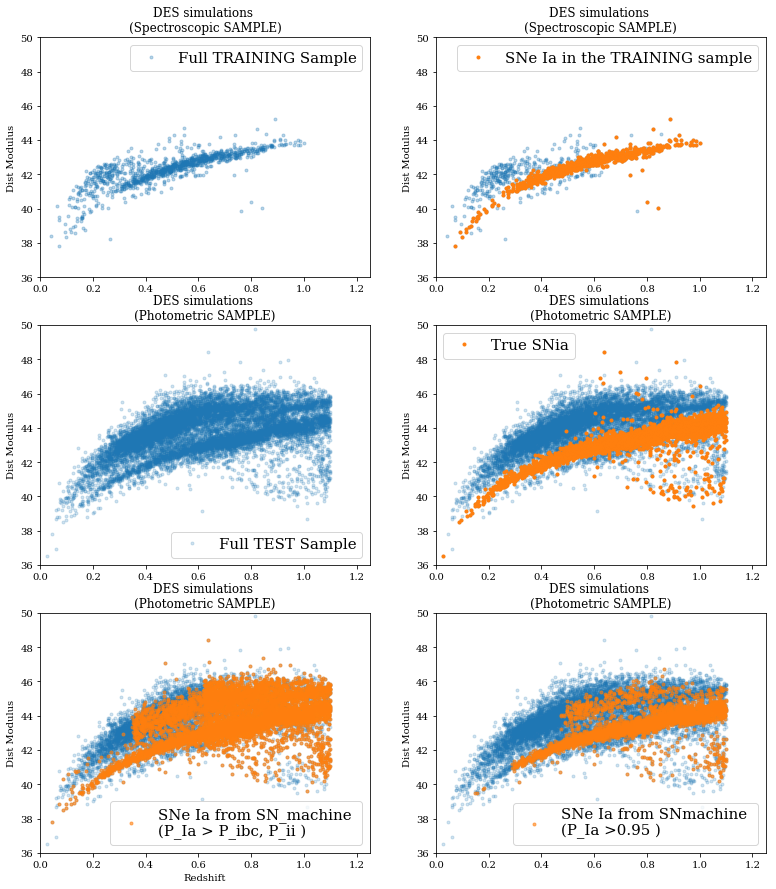

In [18]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_TRAIN, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_TRAIN, '.', alpha=0.3)
plt.plot(X_training[:,0][PIa_TRAIN], mu_TRAIN[PIa_TRAIN], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST, '.', alpha=0.2)
plt.plot(X_testing[:,0][True_ia_TEST], mu_TEST[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST, '.', alpha=0.2)
plt.plot(X_testing[:,0][filterML_highestP], mu_TEST[filterML_highestP], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST, '.', alpha=0.2)
plt.plot(X_testing[:,0][filterML], mu_TEST[filterML], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

results_analysis(probs, Y_test_results)

In [29]:

X_training_noz=np.array(np.vstack((
                               feats_log10_TRAIN[:,30],\
                               feats_log10_TRAIN[:,32],\
                               feats_log10_TRAIN[:,34],\
                              )), dtype=float).T

Y_training_noz=np.array(feats_log10_TRAIN[:,1], dtype=float)
   
Y_training_noz[(Y_training_noz==21) | (Y_training_noz==22) | (Y_training_noz==23)]=2
Y_training_noz[(Y_training_noz==32) | (Y_training_noz==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

X_testing_noz=np.array(np.vstack((
                               feats_log10_TEST[:,30][filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_noz, X_testing_noz))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_noz_scaled = scale_data(X_training_noz, global_mean, global_std)
X_testing_noz_scaled = scale_data(X_testing_noz, global_mean, global_std)

print (X_training_noz.shape)
print (Y_training_noz.shape)
print (X_testing_noz.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_noz set
classifier.fit(X_training_noz_scaled, Y_training_noz)
probs_noz=classifier.predict_proba(X_testing_noz_scaled)    

print (classifier.feature_importances_)


alpha=0.11
beta=2.6

mu_TRAIN_noz=30.-2.5*X_training_noz[:,0]+alpha*X_training_noz[:,1]-beta*X_training_noz[:,2]
mu_TEST_noz=30.-2.5*X_testing_noz[:,0]+alpha*X_testing_noz[:,1]-beta*X_testing_noz[:,2]

PIa_TRAIN_noz=Y_training_noz==1
PIa_TEST_noz=probs_noz[:,0]>0.95

P_ia_ML_noz=probs_noz[:,0]
type_classif_noz=np.array([1+np.argmax([probs_noz[i,0], probs_noz[i,1], probs_noz[i,2]])\
                             for i in range(len(probs_noz[:,0]))])

filterML_noz=P_ia_ML_noz>0.95
filterML_highestP_noz=type_classif_noz==1
PIa_TRAIN_noz=Y_training_noz==1




(1120, 3)
(1120,)
(12264, 3)
[ 0.1726236   0.38867377  0.43870263]


FP 3768 FN 143
TP 3200 TN 5153
########  purity:  46.0
########  efficiency:  96.0
FP 215 FN 1251
TP 2092 TN 8706
########  purity chopping:  91.0
########  efficiency chopping:  63.0


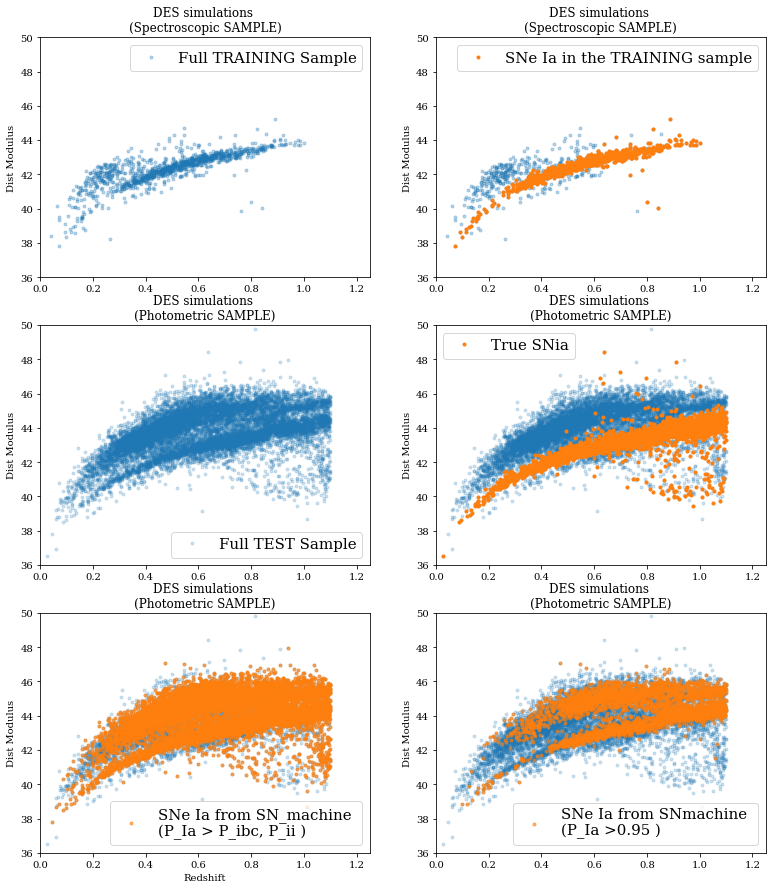

In [25]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_TRAIN_noz, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], mu_TRAIN_noz, '.', alpha=0.3)
plt.plot(X_training[:,0][PIa_TRAIN_noz], mu_TRAIN_noz[PIa_TRAIN_noz], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST_noz, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST_noz, '.', alpha=0.2)
plt.plot(X_testing[:,0][True_ia_TEST], mu_TEST_noz[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST_noz, '.', alpha=0.2)
plt.plot(X_testing[:,0][filterML_highestP_noz], mu_TEST_noz[filterML_highestP_noz], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(X_testing[:,0], mu_TEST_noz, '.', alpha=0.2)
plt.plot(X_testing[:,0][filterML_noz], mu_TEST_noz[filterML_noz], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Dist Modulus')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

results_analysis(probs, Y_test_results)

(array([ 10083.,    450.,    271.,    247.,    135.,    171.,    141.,
           202.,    299.,    265.]),
 array([  2.22044605e-16,   9.90000000e-02,   1.98000000e-01,
          2.97000000e-01,   3.96000000e-01,   4.95000000e-01,
          5.94000000e-01,   6.93000000e-01,   7.92000000e-01,
          8.91000000e-01,   9.90000000e-01]),
 <a list of 10 Patch objects>)

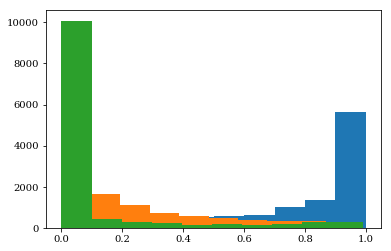

In [17]:
plt.hist(probs_noz[:,0])
plt.hist(probs_noz[:,1])
plt.hist(probs_noz[:,2])


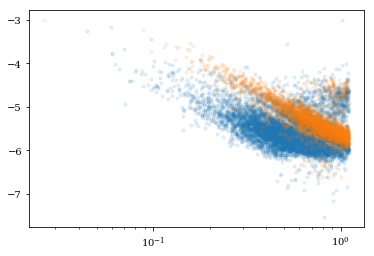

In [18]:
plt.plot(X_testing[:,0][~True_ia_TEST],X_testing[:,1][~True_ia_TEST], '.', alpha=0.1)
plt.plot(X_testing[:,0][True_ia_TEST],X_testing[:,1][True_ia_TEST], '.', alpha=0.1)
plt.xscale('log')



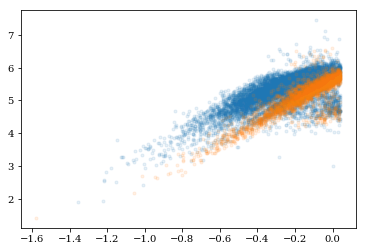

In [19]:
plt.plot(np.log10(X_testing[:,0])[~True_ia_TEST],\
         np.log10(X_testing[:,0])[~True_ia_TEST]-X_testing[:,1][~True_ia_TEST], '.', alpha=0.1)
plt.plot(np.log10(X_testing[:,0][True_ia_TEST]),\
         np.log10(X_testing[:,0][True_ia_TEST])-X_testing[:,1][True_ia_TEST], '.', alpha=0.1)




In [19]:

alpha=0.11
beta=2.6

redshift_TRAIN_wHR= np.array(feats_log10_TRAIN[:,26], dtype=float)
redshift_TEST_wHR= np.array(feats_log10_TEST[:,26], dtype=float)

HRes_TRAIN_wHR=30.-2.5*np.array(feats_log10_TRAIN[:,30],dtype=float)+\
                alpha*np.array(feats_log10_TRAIN[:,32],dtype=float)-\
                beta*np.array(feats_log10_TRAIN[:,34],dtype=float)-\
                cosmo.distmod(redshift_TRAIN_wHR).value
HRes_TEST_wHR=30.-2.5*np.array(feats_log10_TEST[:,30],dtype=float)+\
                alpha*np.array(feats_log10_TEST[:,32],dtype=float)-\
                beta*np.array(feats_log10_TEST[:,34],dtype=float)-\
                cosmo.distmod(redshift_TEST_wHR).value

X_training_wHR=np.array(np.vstack((
                               HRes_TRAIN_wHR,\
                               feats_log10_TRAIN[:,32],\
                               feats_log10_TRAIN[:,34],\
                              )), dtype=float).T

Y_training_wHR=np.array(feats_log10_TRAIN[:,1], dtype=float)
   
Y_training_wHR[(Y_training_wHR==21) | (Y_training_wHR==22) | (Y_training_wHR==23)]=2
Y_training_wHR[(Y_training_wHR==32) | (Y_training_wHR==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

redshift_wHR= np.array(feats_log10_TEST[:,26], dtype=float)[filter_nan]

X_testing_wHR=np.array(np.vstack((
                               HRes_TEST_wHR[filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

HRes_TEST_wHR=HRes_TEST_wHR[filter_nan]
redshift_TEST_wHR=redshift_TEST_wHR[filter_nan]

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_wHR, X_testing_wHR))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_wHR_scaled = scale_data(X_training_wHR, global_mean, global_std)
X_testing_wHR_scaled = scale_data(X_testing_wHR, global_mean, global_std)

print (X_training_wHR.shape)
print (Y_training_wHR.shape)
print (X_testing_wHR.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_wHR set
classifier.fit(X_training_wHR_scaled, Y_training_wHR)
probs_wHR=classifier.predict_proba(X_testing_wHR_scaled)    


PIa_TEST_wHR=probs_wHR[:,0]>0.95
P_ia_ML_wHR=probs_wHR[:,0]
type_classif_wHR=np.array([1+np.argmax([probs_wHR[i,0], probs_wHR[i,1], probs_wHR[i,2]])\
                             for i in range(len(probs_wHR[:,0]))])

filterML_wHR=P_ia_ML_wHR>0.95
filterML_highestP_wHR=type_classif_wHR==1
PIa_TRAIN_wHR=Y_training_wHR==1


(1120, 3)
(1120,)
(12264, 3)


FP 3768 FN 143
TP 3200 TN 5153
########  purity:  46.0
########  efficiency:  96.0
FP 215 FN 1251
TP 2092 TN 8706
########  purity chopping:  91.0
########  efficiency chopping:  63.0
FP 2688 FN 227
TP 3116 TN 6233
########  purity:  54.0
########  efficiency:  93.0
FP 627 FN 1542
TP 1801 TN 8294
########  purity chopping:  74.0
########  efficiency chopping:  54.0


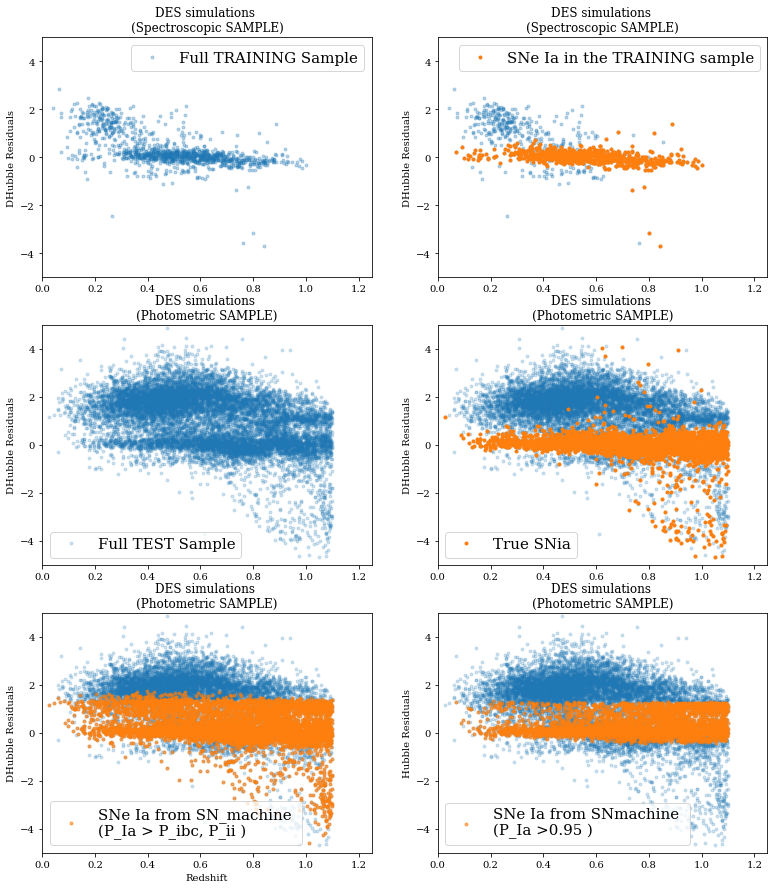

In [21]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], HRes_TRAIN_wHR, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training[:,0], HRes_TRAIN_wHR, '.', alpha=0.3)
plt.plot(X_training[:,0][PIa_TRAIN_wHR], HRes_TRAIN_wHR[PIa_TRAIN_wHR], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR, HRes_TEST_wHR, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR, HRes_TEST_wHR, '.', alpha=0.2)
plt.plot(redshift_wHR[True_ia_TEST], HRes_TEST_wHR[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR, HRes_TEST_wHR, '.', alpha=0.2)
plt.plot(redshift_wHR[filterML_highestP_wHR], HRes_TEST_wHR[filterML_highestP_wHR], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR, HRes_TEST_wHR, '.', alpha=0.2)
plt.plot(redshift_wHR[filterML_wHR], HRes_TEST_wHR[filterML_wHR], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Hubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

results_analysis(probs, Y_test_results)
results_analysis(probs_wHR, Y_test_results)

In [22]:
feat_zsp = [26,28,30,32,34]
feat_zsp_err = [27,29,31,33,35]

filter_nan = np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float))\
                   )[0]

feats_log10_TEST_filtered = feats_log10_TEST[filter_nan]
feats_log10_TEST_filtered[:,1] = Y_test_results


In [23]:
len(feats_log10_TEST_filtered), len(Y_test_results)

(12264, 12264)

In [24]:
np.mean(np.array(feats_log10_TEST_filtered[:,feat_zsp], dtype=float), axis=0)

array([  6.39529167e-01,   2.12428671e+01,  -5.47940656e+00,
         1.11078627e+00,   1.79009681e-02])

In [25]:
def run_ml_lighter(X_train, Y_train, X_test, Y_test, X_train_err, X_test_err, **kwargs):
    
    """
    Optimise, then run each of the classifiers, calculate ROC AUC, F1 and Kessler FoM from 
    their results. Also calculate probabilities and compare with a frequentist probability measure.
    Plots of classifier probability vs. frequency probability are produced for each classifier.
    Note the script pauses as each plot is shown and only resumes once the plot window is closed.
    
    INPUTS:
    X_train - An array of the training set features, of size (N_samples, N_features)
    Y_train - An array of the training set classes, of size (N_samples,). Class labels are 1, 2, 3
    X_test - An array of the testing set features, of size (N_samples, N_features)
    Y_test - An array of the testing set classes, of size (N_samples,). Class labels are 1, 2, 3
    X_train_err - An array of the errors on the training set features, of size (N_samples, N_features)
    X_test_err - An array of the errors on the testing set features, of size (N_samples, N_features)
    
    OUTPUTS:
    results - An array of performance criteria achieved by each classifier, of size (N_classifiers, N_criteria)
    thresholds - An array of the optimum probability threshold for each classifier wrt F1 and FoM, of size
                        (N_classifiers, 2)
    """
    
    n_features = float(X_train.shape[1])
    
    #Find optimum parameters (from a user defined dictionary of possibilities) for each classifier
    NB_params = {}
    RF_param_dict = {'n_estimators':[500, 1000, 1500], 'criterion':['gini', 'entropy']}
    RF_params = grid_search.RF_optimiser(X_train, Y_train, X_test, Y_test, RF_param_dict)
    Boost_param_dict = {'base_estimator':[RandomForestClassifier(400, 'entropy'), RandomForestClassifier(600, 'entropy')], 
                                          'n_estimators':[2, 3, 5, 10]}
    Boost_params = grid_search.Boost_optimiser(X_train, Y_train, X_test, Y_test, Boost_param_dict)
    RBF_param_dict = {'C':[0.5, 1, 2, 4], 'gamma':[1/(n_features**2), 1/n_features, 1/np.sqrt(n_features)]}
    RBF_params = grid_search.RBF_optimiser(X_train, Y_train, X_test, Y_test, RBF_param_dict)
    
    #Run classifiers with 2-fold cross validation
    probsNB=ml_algorithms.bayes(X_train,  Y_train,  X_test)
    probsNB_repeat=ml_algorithms.bayes(X_test, Y_test, X_train)
    probsRF=ml_algorithms.forest(X_train, Y_train, X_test, RF_params['n_estimators'], RF_params['criterion'])
    probsRF_repeat=ml_algorithms.forest(X_test, Y_test, X_train, RF_params['n_estimators'], RF_params['criterion'])
    probsBoost=ml_algorithms.boost_RF(X_train, Y_train, X_test, Boost_params['base_estimator'], Boost_params['n_estimators'])
    probsBoost_repeat=ml_algorithms.boost_RF(X_test, Y_test, X_train, Boost_params['base_estimator'], Boost_params['n_estimators'])
    probsRBF=ml_algorithms.support_vmRBF(X_train, Y_train, X_test, RBF_params['C'], RBF_params['gamma']) 
    probsRBF_repeat=ml_algorithms.support_vmRBF(X_test, Y_test, X_train, RBF_params['C'], RBF_params['gamma'])
    probs_MCS,  hard_indices_test = ml_algorithms.MCSprobs(probsRF, probsRBF,probsBoost)
    probs_MCS_repeat,  hard_indices_train = ml_algorithms.MCSprobs(probsRF_repeat, probsRBF_repeat, probsBoost_repeat)

    #make a record of examples the classifiers in MCS disagreed on
    hard_X_train = X_train[hard_indices_train, :]
    hard_Y_train = Y_train[hard_indices_train]
    hard_X_test = X_test[hard_indices_test, :]
    hard_Y_test = Y_test[hard_indices_test]
    
    #make a record of the FP and FN from RF
    RF_FP, RF_FN,  RF_TP, RF_TN = tools.misclassifications(probsRF, X_test, Y_test)
    """
    #Calculate frequency probabilities
    freq_probsNB = frequency_probabilities(X_train, Y_train, X_test, X_test_err, ml_algorithms.bayes, NB_params)
    freq_probsRF = frequency_probabilities(X_train, Y_train, X_test, X_test_err, ml_algorithms.forest, 
                                           RF_params['n_estimators'], RF_params['criterion'])
    freq_probsBoost = frequency_probabilities(X_train, Y_train, X_test, X_test_err, 
                                              ml_algorithms.boost_RF, Boost_params['base_estimator'], Boost_params['n_estimators'])
    freq_probsRBF = frequency_probabilities(X_train, Y_train, X_test, X_test_err, 
                                            ml_algorithms.support_vmRBF, RBF_params['C'], RBF_params['gamma']) 
    
    #Plot frequency probabilities against classifier probabilities
    plt.figure()    
    plt.scatter(freq_probsNB, probsNB[:, 0])
    plt.title('Naive Bayes - Fake Data')
    plt.xlabel('Real probabilities')
    plt.ylabel('Frequency probabilities')
    plt.savefig('/export/zupcx26/visitor4/Spring_2015/For_Wiki/prob_experiments/NB_RvsF.png', facecolor='white')
    plt.show()
    
    plt.figure()
    plt.title('K Nearest Neighbours')
    plt.xlabel('Real probabilities')
    plt.ylabel('Frequency probabilities')
    plt.show()
    
    plt.figure()
    plt.scatter(freq_probsRF, probsRF[:,0])
    plt.title('Random Forest')
    plt.xlabel('Real probabilities')
    plt.ylabel('Frequency probabilities')
    plt.savefig('/export/zupcx26/visitor4/Spring_2015/For_Wiki/prob_experiments/RF_RvsF.png', facecolor='white')
    plt.show()
    
    plt.figure()
    plt.scatter(freq_probsBoost, probsBoost[:, 0])
    plt.title('AdaBoost Random Forest')
    plt.xlabel('Real probabilities')
    plt.ylabel('Frequency probabilities')
    plt.savefig('/export/zupcx26/visitor4/Spring_2015/For_Wiki/prob_experiments/Boost_RvsF.png', facecolor='white')
    plt.show()
    
    plt.figure()
    plt.scatter(freq_probsRBF, probsRBF[:, 0])
    plt.title('Support Vector Machine with RBF Kernel')
    plt.xlabel('Frequency Probabilities')
    plt.ylabel('Frequency probabilities')
    plt.savefig('/export/zupcx26/visitor4/Spring_2015/For_Wiki/prob_experiments/RBF_RvsF.png', facecolor='white')
    plt.show()
    """
    #calculate ROC curve values
    fNB, tNB, aNB=ml_algorithms.roc(probsNB, Y_test)
    fNB_repeat, tNB_repeat, aNB_repeat=ml_algorithms.roc(probsNB_repeat, Y_train)
    fRF, tRF, aRF=ml_algorithms.roc(probsRF, Y_test)
    fRF_repeat, tRF_repeat, aRF_repeat=ml_algorithms.roc(probsRF_repeat, Y_train)
    fBoost, tBoost, aBoost=ml_algorithms.roc(probsBoost, Y_test)
    fBoost_repeat, tBoost_repeat, aBoost_repeat=ml_algorithms.roc(probsBoost_repeat, Y_train)
    fRBF, tRBF, aRBF=ml_algorithms.roc(probsRBF, Y_test)
    fRBF_repeat, tRBF_repeat, aRBF_repeat=ml_algorithms.roc(probsRBF_repeat, Y_train)
    fMCS,  tMCS, aMCS = ml_algorithms.roc(probs_MCS, Y_test)
    fMCS_repeat, tMCS_repeat, aMCS_repeat = ml_algorithms.roc(probs_MCS_repeat, Y_train)

    #calculate mean AUC over cross validation
    aNB_mean = (aNB+aNB_repeat)/2.0
    aRF_mean = (aRF+aRF_repeat)/2.0
    aBoost_mean = (aBoost+aBoost_repeat)/2.0
    aRBF_mean = (aRBF+aRBF_repeat)/2.0
    aMCS_mean = (aMCS+aMCS_repeat)/2.0
    
    #calculate F1 values
    F1_scoreNB, F1_thresholdNB = ml_algorithms.F1(probsNB, Y_test)
    F1_scoreNB_repeat, F1_thresholdNB_repeat = ml_algorithms.F1(probsNB_repeat, Y_train)
    F1_scoreRF,  F1_thresholdRF = ml_algorithms.F1(probsRF, Y_test)
    F1_scoreRF_repeat,  F1_thresholdRF_repeat = ml_algorithms.F1(probsRF_repeat, Y_train)
    F1_scoreBoost,  F1_thresholdBoost = ml_algorithms.F1(probsBoost, Y_test)
    F1_scoreBoost_repeat,  F1_thresholdBoost_repeat = ml_algorithms.F1(probsBoost_repeat, Y_train)
    F1_scoreRBF, F1_thresholdRBF = ml_algorithms.F1(probsRBF, Y_test)
    F1_scoreRBF_repeat, F1_thresholdRBF_repeat = ml_algorithms.F1(probsRBF_repeat, Y_train)
    F1_scoreMCS, F1_thresholdMCS = ml_algorithms.F1(probs_MCS, Y_test)
    F1_scoreMCS_repeat, F1_thresholdMCS_repeat = ml_algorithms.F1(probs_MCS_repeat, Y_train)
    
    F1_scoreNB_mean = 0.5*(F1_scoreNB+F1_scoreNB_repeat)
    F1_scoreRF_mean = 0.5*(F1_scoreRF+F1_scoreRF_repeat)
    F1_scoreBoost_mean = 0.5*(F1_scoreBoost+F1_scoreBoost_repeat)
    F1_scoreRBF_mean = 0.5*(F1_scoreRBF+F1_scoreRBF_repeat)
    F1_scoreMCS_mean = 0.5*(F1_scoreMCS+F1_scoreMCS_repeat)
    
    #calculate Kessler FoM values
    FoMNB, FoM_thresholdNB = ml_algorithms.FoM(probsNB, Y_test)
    FoMNB_repeat, FoM_thresholdNB_repeat = ml_algorithms.FoM(probsNB_repeat, Y_train)
    FoMRF, FoM_thresholdRF = ml_algorithms.FoM(probsRF, Y_test)
    FoMRF_repeat, FoM_thresholdRF_repeat = ml_algorithms.FoM(probsRF_repeat, Y_train)
    FoMBoost, FoM_thresholdBoost = ml_algorithms.FoM(probsBoost, Y_test)
    FoMBoost_repeat, FoM_thresholdBoost_repeat = ml_algorithms.FoM(probsBoost_repeat, Y_train)
    FoMRBF, FoM_thresholdRBF = ml_algorithms.FoM(probsRBF, Y_test)
    FoMRBF_repeat, FoM_thresholdRBF_repeat = ml_algorithms.FoM(probsRBF_repeat, Y_train)
    FoMMCS, FoM_thresholdMCS = ml_algorithms.FoM(probs_MCS, Y_test)
    FoMMCS_repeat, FoM_thresholdMCS_repeat = ml_algorithms.FoM(probs_MCS_repeat, Y_train)
    
    FoMNB_mean = 0.5*(FoMNB+FoMNB_repeat)
    FoMRF_mean = 0.5*(FoMRF+FoMRF_repeat)
    FoMBoost_mean = 0.5*(FoMBoost+FoMBoost_repeat)
    FoMRBF_mean = 0.5*(FoMRBF+FoMRBF_repeat)
    FoMMCS_mean = 0.5*(FoMMCS+FoMMCS_repeat)
    
    #Collate all results into a results array
    results = np.array([[aRBF_mean, F1_scoreRBF_mean, FoMRBF_mean], 
                                   [aNB_mean, F1_scoreNB_mean, FoMNB_mean], 
                                   [aRF_mean, F1_scoreRF_mean, FoMRF_mean], 
                                   [aBoost_mean, F1_scoreBoost_mean, FoMBoost_mean], 
                                   [aMCS_mean, F1_scoreMCS_mean, FoMMCS_mean]])

    FoMNB, FoM_thresholdNB, Pur_NB, Eff_NB  = ml_algorithms.FoM(probsNB, Y_test, pur_eff=True)
    FoMNB_repeat, FoM_thresholdNB_repeat, Pur_NB_repeat, Eff_NB_repeat  = ml_algorithms.FoM(probsNB_repeat, Y_train, pur_eff=True)
    FoMRF, FoM_thresholdRF, Pur_RF, Eff_RF  = ml_algorithms.FoM(probsRF, Y_test, pur_eff=True)
    FoMRF_repeat, FoM_thresholdRF_repeat, Pur_RF_repeat, Eff_RF_repeat  = ml_algorithms.FoM(probsRF_repeat, Y_train, pur_eff=True)
    FoMBoost, FoM_thresholdBoost, Pur_Boost, Eff_Boost  = ml_algorithms.FoM(probsBoost, Y_test, pur_eff=True)
    FoMBoost_repeat, FoM_thresholdBoost_repeat, Pur_Boost_repeat, Eff_Boost_repeat  = ml_algorithms.FoM(probsBoost_repeat, Y_train, pur_eff=True)
    FoMRBF, FoM_thresholdRBF, Pur_RBF, Eff_RBF  = ml_algorithms.FoM(probsRBF, Y_test, pur_eff=True)
    FoMRBF_repeat, FoM_thresholdRBF_repeat, Pur_RBF_repeat, Eff_RBF_repeat  = ml_algorithms.FoM(probsRBF_repeat, Y_train, pur_eff=True)
    FoMMCS, FoM_thresholdMCS, Pur_MCS, Eff_MCS  = ml_algorithms.FoM(probs_MCS, Y_test, pur_eff=True)
    FoMMCS_repeat, FoM_thresholdMCS_repeat, Pur_MCS_repeat, Eff_MCS_repeat  = ml_algorithms.FoM(probs_MCS_repeat, Y_train, pur_eff=True)
    
    FoMNB_mean = 0.5*(FoMNB+FoMNB_repeat)
    FoMRF_mean = 0.5*(FoMRF+FoMRF_repeat)
    FoMBoost_mean = 0.5*(FoMBoost+FoMBoost_repeat)
    FoMRBF_mean = 0.5*(FoMRBF+FoMRBF_repeat)
    FoMMCS_mean = 0.5*(FoMMCS+FoMMCS_repeat)
    
    Pur_NB_mean = 0.5*(Pur_NB+Pur_NB_repeat)
    Pur_RF_mean = 0.5*(Pur_RF+Pur_RF_repeat)
    Pur_Boost_mean = 0.5*(Pur_Boost+Pur_Boost_repeat)
    Pur_RBF_mean = 0.5*(Pur_RBF+Pur_RBF_repeat)
    Pur_MCS_mean = 0.5*(Pur_MCS+Pur_MCS_repeat)

    Eff_NB_mean = 0.5*(Eff_NB+Eff_NB_repeat)
    Eff_RF_mean = 0.5*(Eff_RF+Eff_RF_repeat)
    Eff_Boost_mean = 0.5*(Eff_Boost+Eff_Boost_repeat)
    Eff_RBF_mean = 0.5*(Eff_RBF+Eff_RBF_repeat)
    Eff_MCS_mean = 0.5*(Eff_MCS+Eff_MCS_repeat)

    #Collate all results into a results array
    results = np.array([[aRBF_mean, F1_scoreRBF_mean, FoMRBF_mean], 
                                   [aNB_mean, F1_scoreNB_mean, FoMNB_mean], 
                                   [aRF_mean, F1_scoreRF_mean, FoMRF_mean], 
                                   [aBoost_mean, F1_scoreBoost_mean, FoMBoost_mean], 
                                   [aMCS_mean, F1_scoreMCS_mean, FoMMCS_mean]])


    thresholds = np.array([[F1_thresholdRBF, FoM_thresholdRBF], 
                                        [F1_thresholdNB, FoM_thresholdNB], 
                                        [F1_thresholdRF, FoM_thresholdRF], 
                                        [F1_thresholdBoost, FoM_thresholdBoost], 
                                        [F1_thresholdMCS, FoM_thresholdMCS]])
    
    #Print best performance criteria for each classifier  
    #print ('AUC, F1, FoM, Purity, Efficiency:')
    #print ('RBF SVM',  results[0, 0],  results[0, 1],  results[0, 2])
    #print ('Bayes', results[1, 0],  results[1, 1], results[1, 2])
    #print ('Random forest', results[3, 0],  results[3, 1],  results[3, 2])
    #print ('AdaBoost forest',  results[4, 0],  results[4, 1],  results[4, 2])
    #print ('MCS',  results[6, 0], results[6, 1], results[6, 2])

    #print ('Purity, Efficiency:')
    #print ('RBF SVM', Purities[0],  Efficiencies[0])
    #print ('Bayes', Purities[1],  Efficiencies[1])
    #print ('Random forest', Purities[3],  Efficiencies[3])
    #print ('AdaBoost forest', Purities[4],  Efficiencies[4])
    #print ('MCS', Purities[6],  Efficiencies[6])
    plot2_ROC(fRBF, tRBF, fNB, tNB, fRF, tRF, fBoost, tBoost, fMCS, tMCS, aRBF_mean, 
             aNB_mean, aRF_mean, aBoost_mean, aMCS_mean)

    return results, thresholds, probsRF, probsRF_repeat

In [26]:
X_combined, Y_keys , Sh, mean_zsp, std_zsp= prepare_data4ml_algorithms(feats_log10_TEST_filtered, feat_zsp, feat_zsp_err)
RES_full_sample=run_ml_plot(X_combined, Y_keys, Sh, lighter_version=True)

[ 1 33 33 ..., 22  1 22] [[  0.6267    6.275    -5.083     0.3125   -0.03885]
 [  0.5473   26.62     -5.912    -3.        0.1346 ]
 [  0.4239   20.36     -5.548    -0.5886    0.5    ]
 ..., 
 [  0.3281    8.705    -5.232     1.753     0.2881 ]
 [  0.712    24.53     -5.357    -0.2992    0.03571]
 [  0.2329   23.67     -5.354    -0.9388    0.5    ]] [  6.39529167e-01   2.12428671e+01  -5.47940656e+00   1.11078627e+00
   1.79009681e-02]
scale_data_with_errors [  6.39529167e-01   2.12428671e+01  -5.47940656e+00   1.11078627e+00
   1.79009681e-02] [  0.23681353  24.64717412   0.41151673   1.9483525    0.25951929]
('FeatImp', array([ 0.15232446,  0.13554101,  0.14768935,  0.29503067,  0.26941451]))
('FeatImp', array([ 0.15949442,  0.14434926,  0.16027774,  0.27462332,  0.26125526]))
('FeatImp', array([ 0.15159126,  0.13526247,  0.14689869,  0.29706787,  0.26917972]))
('FeatImp', array([ 0.15965882,  0.14201589,  0.16158069,  0.27645063,  0.26029397]))
('FeatImp', array([ 0.15084268,  0.1343

NameError: global name 'plot2_ROC' is not defined

In [ ]:
X, Y, FN_Ia, FP_Ia, TP_Ia, TN_Ia= results_analysis(RES_full_sample, Y_training)

In [ ]:
Y_training

In [ ]:
def plot2_ROC(fRBF, tRBF, fNB, tNB, fRF, tRF, fBoost, tBoost, fMCS, tMCS, aRBF_mean, 
             aNB_mean, aRF_mean, aBoost_mean, aMCS_mean):
    """
    Plot ROC curves comparing the performance of all the classifiers.
    
    INPUTS:
    fX - An array of the false positive rate for classifier X, of size (N_threshold_increments,)
    tX - An array of the true positive rate for classifier X, of size (N_threshold_increments,)
    aX_mean - The mean ROC AUC value for classifier X
    
    OUTPUTS:
    - A plot of the ROC curves is shown, and the script pauses until the plot window is closed
    
    """
    
    #Create figure for ROC curve
    plt.figure(figsize=(10, 10))

    CANN='#a21d21' #brown
    CNB='#185aa9' #blue
    CKNN='#fdff00' #yellow
    CRF='#008c48' #purple
    CMCS ='#e74c3c' #red
    CBoost ='#fd85ec' #pink
    CRBF ='#40e0d0' #cyan
    
    linew=2.5

    #plot ROC curves
    plt.plot(fRBF, tRBF, CRBF, lw=linew)
    plt.plot(fNB, tNB, CNB, lw=linew)
    plt.plot(fRF, tRF, CRF, lw=linew)
    plt.plot(fBoost, tBoost, CBoost, lw=linew)
    plt.plot(fMCS, tMCS, CMCS, lw=linew)
    
    #plot the RF threshold = 0.5 point
    midX = int(round(fRF.shape[0]/2.0))
    midY = int(round(tRF.shape[0]/2.0))
    plt.scatter(fRF[midX], tRF[midY], s=200, c='#000000')
    
    #Set plot parameters
    #ax=plt.gca()
    #ax.set_aspect(1.0)
    #plt.setup_plot(ax)
    #
    #Create legend
    plt.legend(('RBF SVM (%.3f)' %(aRBF_mean),  'Naive Bayes (%.3f)' %(aNB_mean),
    'Random Forest (%.3f)' %(aRF_mean), 'Ada Forest (%.3f)' %(aBoost_mean),
    'MCS (%.3f)' %(aMCS_mean)),  loc='lower right',  frameon=True, bbox_to_anchor=(0.95, 0.05), fontsize=18)
    
    plt.title('ROC Curve', fontsize=22)
    plt.xlabel('False positive rate (contamination)', fontsize=18)
    plt.ylabel('True positive rate (recall)', fontsize=18)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    plt.subplots_adjust(bottom=0.08,left=0.05, top=0.92, right=0.95)
    #plt.savefig('/export/zupcx26/visitor4/Spring_2015/For_Wiki/ROC.png')
    plt.show()
    

In [30]:
import random
feats_log10_TEST = np.genfromtxt('/Users/mariavincenzi/PhD/SNChallenge/ml_esac/salt2_fit_TEST_sample_log10x0_mb_cov.txt',\
                            dtype='str', comments='#')

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]


feats_log10_REPRESENTATIVE = np.array([feats_log10_TEST[filter_nan][random.randint(0, len(feats_log10_TEST[filter_nan])-1)]\
                                       for j in range(1119)])

In [34]:
des_file_associated=feats_log10_REPRESENTATIVE[:,0]

Y_TEST_REPR_results=[]
for des_snid in des_file_associated:
    try:
        CID=int((des_snid.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        Y_TEST_REPR_results.append(data_results['GENTYPE'][ind_corrispondent][0])
    except ValueError:
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
#        print (ind_corrispondent, data_results['GENTYPE'][ind_corrispondent][0])
        print ('No type for', des_snid)
        Y_TEST_REPR_results.append(np.nan)



In [53]:

alpha=0.11
beta=2.6

redshift_TRAIN_repr= np.array(feats_log10_REPRESENTATIVE[:,26], dtype=float)
redshift_TEST_repr= np.array(feats_log10_TEST[:,26], dtype=float)

Mu_TRAIN_repr=30.-2.5*np.array(feats_log10_REPRESENTATIVE[:,30],dtype=float)+\
                alpha*np.array(feats_log10_REPRESENTATIVE[:,32],dtype=float)-\
                beta*np.array(feats_log10_REPRESENTATIVE[:,34],dtype=float)
        
Mu_TEST_repr=30.-2.5*np.array(feats_log10_TEST[:,30],dtype=float)+\
                alpha*np.array(feats_log10_TEST[:,32],dtype=float)-\
                beta*np.array(feats_log10_TEST[:,34],dtype=float)

X_training_repr=np.array(np.vstack((redshift_TRAIN_repr,
                               feats_log10_REPRESENTATIVE[:,30],\
                               feats_log10_REPRESENTATIVE[:,32],\
                               feats_log10_REPRESENTATIVE[:,34],\
                              )), dtype=float).T

Y_training_repr=np.array(Y_TEST_REPR_results, dtype=float)
   
Y_training_repr[(Y_training_repr==21) | (Y_training_repr==22) | (Y_training_repr==23)]=2
Y_training_repr[(Y_training_repr==32) | (Y_training_repr==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

redshift_repr= np.array(feats_log10_TEST[:,26], dtype=float)[filter_nan]

X_testing_repr=np.array(np.vstack((redshift_repr,
                               feats_log10_TEST[:,30][filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

Mu_TEST_repr=Mu_TEST_repr[filter_nan]
redshift_TEST_repr=redshift_TEST_repr[filter_nan]

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_repr, X_testing_repr))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_repr_scaled = scale_data(X_training_repr, global_mean, global_std)
X_testing_repr_scaled = scale_data(X_testing_repr, global_mean, global_std)

print (X_training_repr.shape)
print (Y_training_repr.shape)
print (X_testing_repr.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_repr set
classifier.fit(X_training_repr_scaled, Y_training_repr)
probs_repr=classifier.predict_proba(X_testing_repr_scaled)    


PIa_TEST_repr=probs_repr[:,0]>0.95
P_ia_ML_repr=probs_repr[:,0]
type_classif_repr=np.array([1+np.argmax([probs_repr[i,0], probs_repr[i,1], probs_repr[i,2]])\
                             for i in range(len(probs_repr[:,0]))])

filterML_repr=P_ia_ML_repr>0.95
filterML_highestP_repr=type_classif_repr==1
PIa_TRAIN_repr=Y_training_repr==1




(1119, 4)
(1119,)
(12264, 4)


FP 3747 FN 144
TP 3199 TN 5174
########  purity:  46.0
########  efficiency:  96.0
FP 227 FN 1226
TP 2117 TN 8694
########  purity chopping:  90.0
########  efficiency chopping:  63.0
FP 307 FN 462
TP 2881 TN 8614
########  purity:  90.0
########  efficiency:  86.0
FP 2 FN 2962
TP 381 TN 8919
########  purity chopping:  99.0
########  efficiency chopping:  11.0


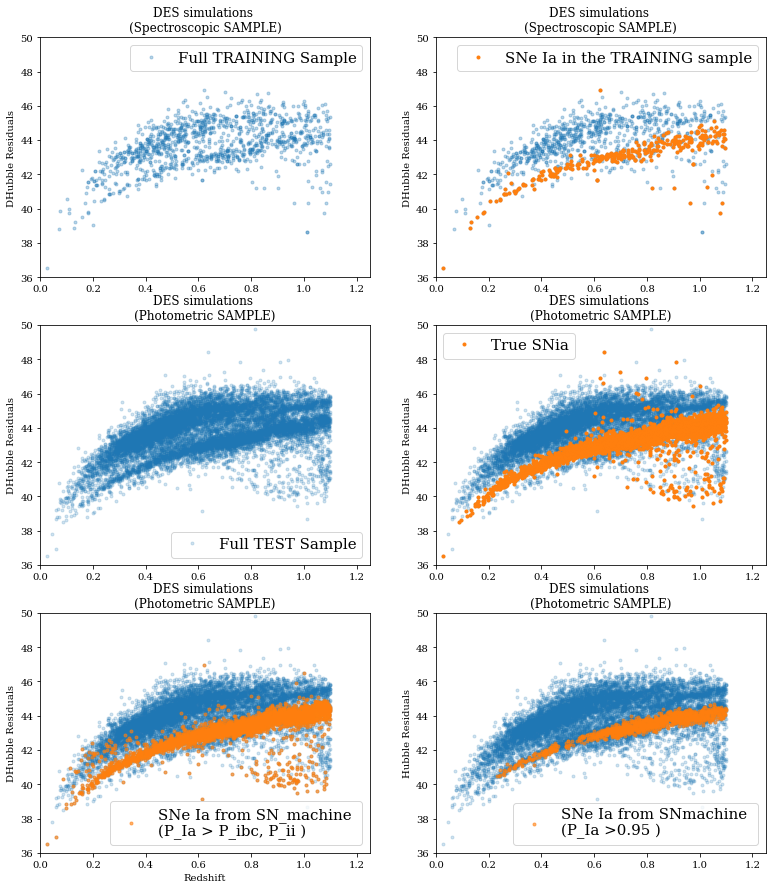

In [55]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_repr[:,0], Mu_TRAIN_repr, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_repr[:,0], Mu_TRAIN_repr, '.', alpha=0.3)
plt.plot(X_training_repr[:,0][PIa_TRAIN_repr], Mu_TRAIN_repr[PIa_TRAIN_repr], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr, Mu_TEST_repr, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr, Mu_TEST_repr, '.', alpha=0.2)
plt.plot(redshift_repr[True_ia_TEST], Mu_TEST_repr[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr, Mu_TEST_repr, '.', alpha=0.2)
plt.plot(redshift_repr[filterML_highestP_repr], Mu_TEST_repr[filterML_highestP_repr], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr, Mu_TEST_repr, '.', alpha=0.2)
plt.plot(redshift_repr[filterML_repr], Mu_TEST_repr[filterML_repr], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Hubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

results_analysis(probs, Y_test_results)
results_analysis(probs_repr, Y_test_results)

In [39]:

alpha=0.11
beta=2.6

redshift_TRAIN_wHR_repr= np.array(feats_log10_REPRESENTATIVE[:,26], dtype=float)
redshift_TEST_wHR_repr= np.array(feats_log10_TEST[:,26], dtype=float)

HRes_TRAIN_wHR_repr=30.-2.5*np.array(feats_log10_REPRESENTATIVE[:,30],dtype=float)+\
                alpha*np.array(feats_log10_REPRESENTATIVE[:,32],dtype=float)-\
                beta*np.array(feats_log10_REPRESENTATIVE[:,34],dtype=float)-\
                cosmo.distmod(redshift_TRAIN_wHR_repr).value
HRes_TEST_wHR_repr=30.-2.5*np.array(feats_log10_TEST[:,30],dtype=float)+\
                alpha*np.array(feats_log10_TEST[:,32],dtype=float)-\
                beta*np.array(feats_log10_TEST[:,34],dtype=float)-\
                cosmo.distmod(redshift_TEST_wHR_repr).value

X_training_wHR_repr=np.array(np.vstack((redshift_TRAIN_wHR_repr,
                               HRes_TRAIN_wHR_repr,\
                               feats_log10_REPRESENTATIVE[:,32],\
                               feats_log10_REPRESENTATIVE[:,34],\
                              )), dtype=float).T

Y_training_wHR_repr=np.array(Y_TEST_REPR_results, dtype=float)
   
Y_training_wHR_repr[(Y_training_wHR_repr==21) | (Y_training_wHR_repr==22) | (Y_training_wHR_repr==23)]=2
Y_training_wHR_repr[(Y_training_wHR_repr==32) | (Y_training_wHR_repr==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

redshift_wHR_repr= np.array(feats_log10_TEST[:,26], dtype=float)[filter_nan]

X_testing_wHR_repr=np.array(np.vstack((redshift_wHR_repr,
                               HRes_TEST_wHR_repr[filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

HRes_TEST_wHR_repr=HRes_TEST_wHR_repr[filter_nan]
redshift_TEST_wHR_repr=redshift_TEST_wHR_repr[filter_nan]

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_wHR_repr, X_testing_wHR_repr))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_wHR_repr_scaled = scale_data(X_training_wHR_repr, global_mean, global_std)
X_testing_wHR_repr_scaled = scale_data(X_testing_wHR_repr, global_mean, global_std)

print (X_training_wHR_repr.shape)
print (Y_training_wHR_repr.shape)
print (X_testing_wHR_repr.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_wHR_repr set
classifier.fit(X_training_wHR_repr_scaled, Y_training_wHR_repr)
probs_wHR_repr=classifier.predict_proba(X_testing_wHR_repr_scaled)    


PIa_TEST_wHR_repr=probs_wHR_repr[:,0]>0.95
P_ia_ML_wHR_repr=probs_wHR_repr[:,0]
type_classif_wHR_repr=np.array([1+np.argmax([probs_wHR_repr[i,0], probs_wHR_repr[i,1], probs_wHR_repr[i,2]])\
                             for i in range(len(probs_wHR_repr[:,0]))])

filterML_wHR_repr=P_ia_ML_wHR_repr>0.95
filterML_highestP_wHR_repr=type_classif_wHR_repr==1
PIa_TRAIN_wHR_repr=Y_training_wHR_repr==1



(1119, 4)
(1119,)
(12264, 4)


FP 3747 FN 144
TP 3199 TN 5174
########  purity:  46.0
########  efficiency:  96.0
FP 227 FN 1226
TP 2117 TN 8694
########  purity chopping:  90.0
########  efficiency chopping:  63.0
FP 334 FN 317
TP 3026 TN 8587
########  purity:  90.0
########  efficiency:  91.0
FP 3 FN 2506
TP 837 TN 8918
########  purity chopping:  100.0
########  efficiency chopping:  25.0


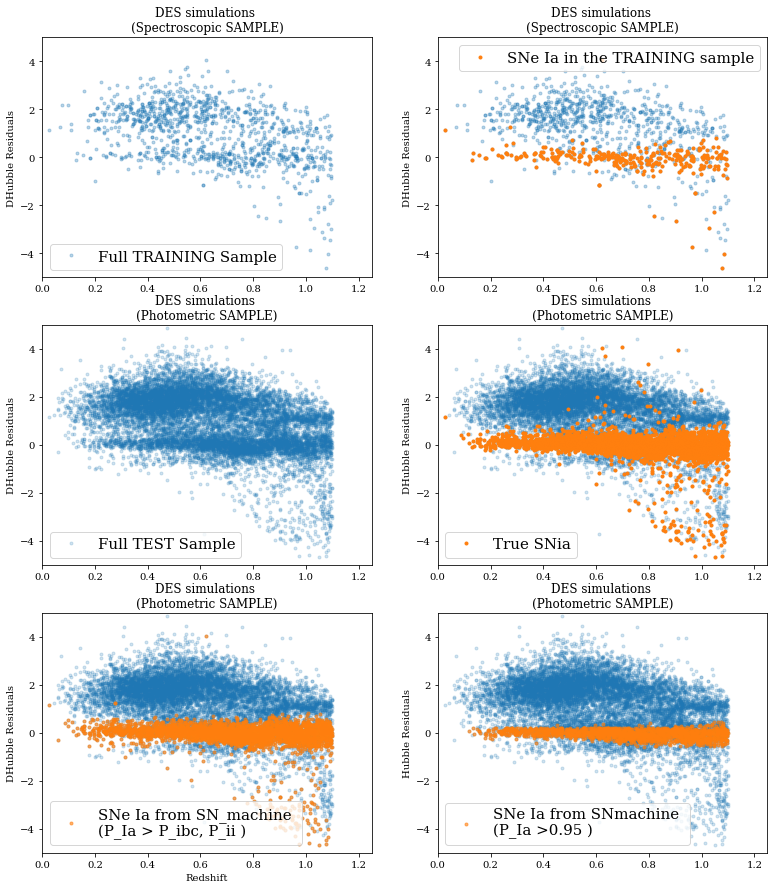

In [43]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_wHR_repr[:,0], HRes_TRAIN_wHR_repr, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_wHR_repr[:,0], HRes_TRAIN_wHR_repr, '.', alpha=0.3)
plt.plot(X_training_wHR_repr[:,0][PIa_TRAIN_wHR_repr], HRes_TRAIN_wHR_repr[PIa_TRAIN_wHR_repr], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR_repr, HRes_TEST_wHR_repr, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR_repr, HRes_TEST_wHR_repr, '.', alpha=0.2)
plt.plot(redshift_wHR_repr[True_ia_TEST], HRes_TEST_wHR_repr[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR_repr, HRes_TEST_wHR_repr, '.', alpha=0.2)
plt.plot(redshift_wHR_repr[filterML_highestP_wHR_repr], HRes_TEST_wHR_repr[filterML_highestP_wHR_repr], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_wHR_repr, HRes_TEST_wHR_repr, '.', alpha=0.2)
plt.plot(redshift_wHR_repr[filterML_wHR_repr], HRes_TEST_wHR_repr[filterML_wHR_repr], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Hubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(-5,5)

results_analysis(probs_wHR_repr, Y_test_results)

In [89]:
Y_TEST_REPR_lessCC=[]
feats_log10_REPRESENTATIVE_lessCC=[]
for j in range(2500):
    selected_SN = feats_log10_TEST[filter_nan][random.randint(0, len(feats_log10_TEST[filter_nan])-1)]
    des_file =  selected_SN[0]
    try:
        CID=int((des_file.replace('DES_SN','')).replace('.DAT',''))
        ind_corrispondent=np.where(data_results['CID']==CID)[0]
        SN_type = data_results['GENTYPE'][ind_corrispondent][0]
    except ValueError:
        SN_type = np.nan
    if SN_type==1.:
        feats_log10_REPRESENTATIVE_lessCC.append(selected_SN)
        Y_TEST_REPR_lessCC.append(SN_type)
    else:
        if j>2250:
            feats_log10_REPRESENTATIVE_lessCC.append(selected_SN)
            Y_TEST_REPR_lessCC.append(SN_type)


Y_TEST_REPR_lessCC=np.array(Y_TEST_REPR_lessCC)
feats_log10_REPRESENTATIVE_lessCC=np.array(feats_log10_REPRESENTATIVE_lessCC)

In [90]:
print (len(feats_log10_REPRESENTATIVE_lessCC))
print (len(np.where(Y_TEST_REPR_lessCC==1)[0]))
print (len(np.where(Y_TEST_REPR_results==1)[0]))

857
665
299


In [91]:

alpha=0.11
beta=2.6

redshift_TRAIN_repr_lessCC= np.array(feats_log10_REPRESENTATIVE_lessCC[:,26], dtype=float)
redshift_TEST_repr_lessCC= np.array(feats_log10_TEST[:,26], dtype=float)

Mu_TRAIN_repr_lessCC=30.-2.5*np.array(feats_log10_REPRESENTATIVE_lessCC[:,30],dtype=float)+\
                alpha*np.array(feats_log10_REPRESENTATIVE_lessCC[:,32],dtype=float)-\
                beta*np.array(feats_log10_REPRESENTATIVE_lessCC[:,34],dtype=float)
        
Mu_TEST_repr_lessCC=30.-2.5*np.array(feats_log10_TEST[:,30],dtype=float)+\
                alpha*np.array(feats_log10_TEST[:,32],dtype=float)-\
                beta*np.array(feats_log10_TEST[:,34],dtype=float)

X_training_repr_lessCC=np.array(np.vstack((redshift_TRAIN_repr_lessCC,
                               feats_log10_REPRESENTATIVE_lessCC[:,30],\
                               feats_log10_REPRESENTATIVE_lessCC[:,32],\
                               feats_log10_REPRESENTATIVE_lessCC[:,34],\
                              )), dtype=float).T

Y_training_repr_lessCC=np.array(Y_TEST_REPR_lessCC, dtype=float)
   
Y_training_repr_lessCC[(Y_training_repr_lessCC==21) | (Y_training_repr_lessCC==22) | (Y_training_repr_lessCC==23)]=2
Y_training_repr_lessCC[(Y_training_repr_lessCC==32) | (Y_training_repr_lessCC==33)]=3

filter_nan=np.where(~np.isnan(np.array(feats_log10_TEST[:,30], dtype=float)))[0]

redshift_repr_lessCC= np.array(feats_log10_TEST[:,26], dtype=float)[filter_nan]

X_testing_repr_lessCC=np.array(np.vstack((redshift_repr_lessCC,
                               feats_log10_TEST[:,30][filter_nan],\
                               feats_log10_TEST[:,32][filter_nan],\
                               feats_log10_TEST[:,34][filter_nan],\
                              )), dtype=float).T

Mu_TEST_repr_lessCC=Mu_TEST_repr_lessCC[filter_nan]
redshift_TEST_repr_lessCC=redshift_TEST_repr_lessCC[filter_nan]

ARG=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
n_est=5

Combine=np.vstack((X_training_repr_lessCC, X_testing_repr_lessCC))
Combined_scaled, global_mean, global_std = scale_data(Combine, ret=True)

X_training_repr_lessCC_scaled = scale_data(X_training_repr_lessCC, global_mean, global_std)
X_testing_repr_lessCC_scaled = scale_data(X_testing_repr_lessCC, global_mean, global_std)

print (X_training_repr_lessCC.shape)
print (Y_training_repr_lessCC.shape)
print (X_testing_repr_lessCC.shape)

from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier

classifier = AdaBoostClassifier(base_estimator = ARG, n_estimators = n_est)
    
#Train the classifier, and use it to classify the testing_repr_lessCC set
classifier.fit(X_training_repr_lessCC_scaled, Y_training_repr_lessCC)
probs_repr_lessCC=classifier.predict_proba(X_testing_repr_lessCC_scaled)    


PIa_TEST_repr_lessCC=probs_repr_lessCC[:,0]>0.95
P_ia_ML_repr_lessCC=probs_repr_lessCC[:,0]
type_classif_repr_lessCC=np.array([1+np.argmax([probs_repr_lessCC[i,0], probs_repr_lessCC[i,1], probs_repr_lessCC[i,2]])\
                             for i in range(len(probs_repr_lessCC[:,0]))])

filterML_repr_lessCC=P_ia_ML_repr_lessCC>0.95
filterML_highestP_repr_lessCC=type_classif_repr_lessCC==1
PIa_TRAIN_repr_lessCC=Y_training_repr_lessCC==1





(857, 4)
(857,)
(12264, 4)


FP 3747 FN 144
TP 3199 TN 5174
########  purity:  46.0
########  efficiency:  96.0
FP 227 FN 1226
TP 2117 TN 8694
########  purity chopping:  90.0
########  efficiency chopping:  63.0
FP 1898 FN 72
TP 3271 TN 7023
########  purity:  63.0
########  efficiency:  98.0
FP 26 FN 1745
TP 1598 TN 8895
########  purity chopping:  98.0
########  efficiency chopping:  48.0


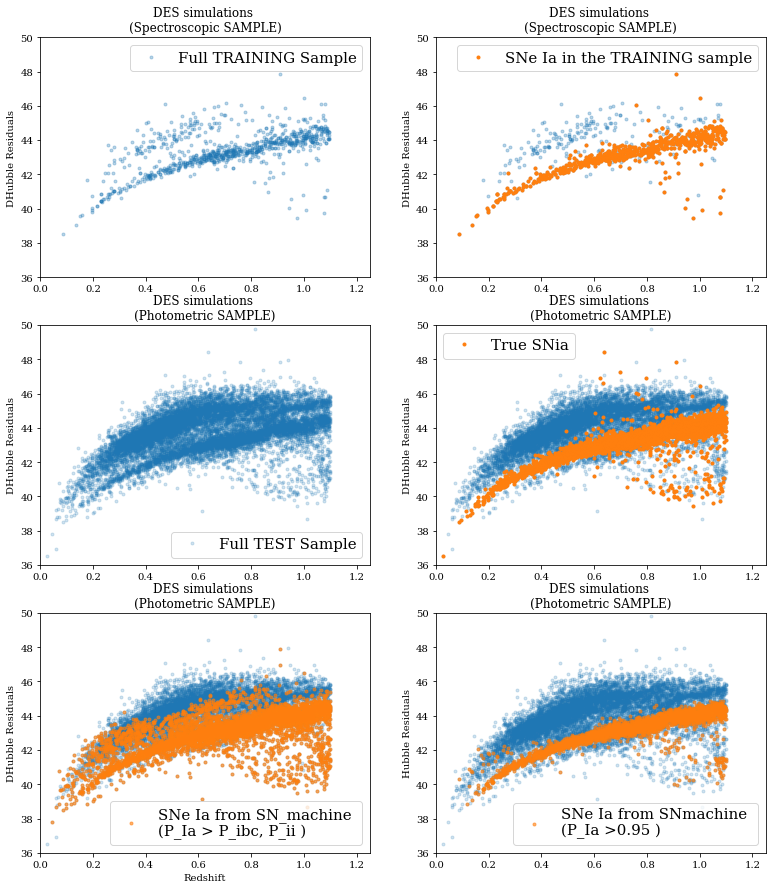

In [92]:
fig=plt.figure(1,figsize=(13,15))

plt.subplot(321)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_repr_lessCC[:,0], Mu_TRAIN_repr_lessCC, '.', alpha=0.3, label='Full TRAINING Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(322)
plt.title('DES simulations \n(Spectroscopic SAMPLE)')
plt.plot(X_training_repr_lessCC[:,0], Mu_TRAIN_repr_lessCC, '.', alpha=0.3)
plt.plot(X_training_repr_lessCC[:,0][PIa_TRAIN_repr_lessCC], Mu_TRAIN_repr_lessCC[PIa_TRAIN_repr_lessCC], '.', label='SNe Ia in the TRAINING sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(323)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr_lessCC, Mu_TEST_repr_lessCC, '.', alpha=0.2,label='Full TEST Sample')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(324)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr_lessCC, Mu_TEST_repr_lessCC, '.', alpha=0.2)
plt.plot(redshift_repr_lessCC[True_ia_TEST], Mu_TEST_repr_lessCC[True_ia_TEST], '.', label='True SNia')
#plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(325)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr_lessCC, Mu_TEST_repr_lessCC, '.', alpha=0.2)
plt.plot(redshift_repr_lessCC[filterML_highestP_repr_lessCC], Mu_TEST_repr_lessCC[filterML_highestP_repr_lessCC], \
         '.', alpha=0.6, label='SNe Ia from SN_machine \n(P_Ia > P_ibc, P_ii )')
plt.xlabel('Redshift')
plt.ylabel('DHubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

plt.subplot(326)
plt.title('DES simulations \n(Photometric SAMPLE)')
plt.plot(redshift_repr_lessCC, Mu_TEST_repr_lessCC, '.', alpha=0.2)
plt.plot(redshift_repr_lessCC[filterML_repr_lessCC], Mu_TEST_repr_lessCC[filterML_repr_lessCC], \
         '.', alpha=0.6,label='SNe Ia from SNmachine \n(P_Ia >0.95 )')
#plt.xlabel('Redshift')
plt.ylabel('Hubble Residuals')
plt.legend(loc='best', fontsize=15)
plt.xlim(0,1.25)
plt.ylim(36,50)

results_analysis(probs_repr_lessCC, Y_test_results)

In [93]:
Y_TEST_REPR_results=np.array(Y_TEST_REPR_results)

print (len(np.where(Y_TEST_REPR_lessCC==1)[0]))
print (len(np.where(Y_TEST_REPR_results==1)[0]))

665
299


In [96]:
data_results

array([ ('SN:', 101953, 3, -9, 0.70257, 0.64937, 0.0329, 0, 52.5, -27.5, 0.0096593, 43.318, 56267.0, 28.067, 25.414, 24.871, 24.557, 1.9842, 3.7169, 4.5653, 7.8966, 7.8966, 4.5653, 3.7169, 0.0, 0.0, 93, -17.556, 49.436, 7.0504, 0.0, 2.1795, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ('SN:', 57351, 3, -9, 0.60522, 0.59962, 0.0257, 1, 34.5, -5.5, 0.022713, 42.923, 56230.0, 26.244, 23.898, 23.637, 23.287, 2.6373, 14.077, 19.227, 17.756, 19.227, 17.756, 14.077, 0.0, 0.0, 104, -14.304, 59.756, 6.2248, 0.0, 2.1796, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ('SN:', 31158, 3, -9, 0.7985, 0.7961, 0.0232, 0, 52.5, -27.5, 0.0096593, 43.658, 56239.0, 28.844, 26.18, 25.08, 24.897, 1.5084, 3.6698, 4.6915, 5.7629, 5.7629, 4.6915, 3.6698, 0.0, 0.0, 133, -15.886, 62.472, 6.6744, 0.0, 2.1794, -9.0, -9.0, -9.0, -9.0, -9.0, -9.0),
       ...,
       ('SN:', 118986, 1, -9, 0.36586, 0.35556, 0.0326, 2, 36.75, -4.5, 0.028275, 41.618, 56358.0, 22.365, 21.583, 21.582, 22.031, 21.042, 42.238, 28.903, 17.656,